# 训练思路

Logic：仅预测撂荒地上光伏建设概率即可，加入多时序可以丰富样本信息、学习到增量样本表示

数据流：


输入：
1、训练样本（划分训练集、测试集合）：美国光伏正样本；
2、预测样本：美国光伏用地；

输出：得到

数据操作：

（先用QQ图观察各个数据的分布特征）对于符合正态分布特征可以直接进入聚类；

1、样本标准化；
2、


后期数据补齐（后期模型优化需要注意的point）
1、Y数据源统一的问题；
2、R语言包问题解决；d
3、提取光伏Y=1正标签对应的landcover序列

# Load Data

In [1]:
from function import *
import pandas as pd
import pandas as pd
import geopandas as gpd
from typing import Sequence



abandon_2d_variable = [
    "current_abandonment",
    "recultivation", 
    "abandonment_duration",
    "abandonment_year"
]
fea_3d_variable = [
    'GDPpc',
    'GDPtot',
    'GURdist',
    'Population',
    'gdmp',
    'rsds',
    'tas',
    'wind'
]
fea_2d_variable = [
    'DEM',
    'Powerdist',
    'PrimaryRoad',
    'SecondaryRoad',
    'Slope',
    'TertiaryRoad'
]
PATHS = {
    'abandonment': "D:/xarray/abandonment_chunkall/*.nc",
    'feature':     "D:/xarray/aligned2/Feature_all/*.nc",
    'csv':         "aligned_for_training0519.csv",
    'prediction':  "",
    'prediction_us': "",
    'test_output': "positive_samples_test_500.csv",
    'output':      "positive_samples_full_with_features.csv",
    'CN_sheng': r'data\sheng2022.shp',
    'World_shp': r'data\main_ADM_0.shp', 
    'us_abandon': r'data\us_abandon_clean.csv',
    'us_pv_embedding': r'data\training_embedding.csv'
}

ZERO_COLS = [
     'GDPpc', 'GDPtot', 'GURdist', 'Population',
    'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'gdmp'
]
YEARS = [2018, 2020]

NUMERIC_FEATURES = [
    'lat','lon','GDPpc', 'GDPtot', 'GURdist', 'DEM','Slope',
    'Population','Powerdist','PrimaryRoad','SecondaryRoad','TertiaryRoad',
    'gdmp','rsds','tas','wind'
]
CAT_COLS = ['landcover']

ABANDON_COLS = ['abandonment_year','abandonment_duration', 'current_abandonment']

NONE_ABANDON_COLS = ['recultivation']

time=['2018-01-01','2020-01-01']







gogogo


# 一阶段相似性建模

## 数据检查

In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import (
    FunctionTransformer, QuantileTransformer,
    StandardScaler, MinMaxScaler, RobustScaler,
    OneHotEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from function.data_utils import NUMERIC_FEATURES, CAT_COLS, ZERO_COLS, ABANDON_COLS, NONE_ABANDON_COLS
from function import *
import matplotlib.pyplot as plt


def check_transformed_data(X_trans, preproc, df_pos, feature_groups):
    """
    检查转换后的数据质量
    
    Args:
        X_trans: 转换后的数据
        preproc: ColumnTransformer对象
        df_pos: 原始数据
        feature_groups: 特征分组字典
    """
    # print("1. 基本检查:")
    # print("  - 包含NaN:", np.isnan(X_trans).any())
    # print("  - 包含inf:", np.isinf(X_trans).any())
    # print("  - Shape:", X_trans.shape)
    
    # print("\n2. 数值统计:")
    # print("  - 最小值:", X_trans.min())
    # print("  - 最大值:", X_trans.max())
    # print("  - 均值:", X_trans.mean())
    # print("  - 标准差:", X_trans.std())
    
    # 检查每个特征组的转换结果
    print("\n3. 特征组统计:")
    start_idx = 0
    for name, transformer in preproc.named_transformers_.items():
        if hasattr(transformer, 'n_features_out_'):
            n_features = transformer.n_features_out_
            group_data = X_trans[:, start_idx:start_idx + n_features]
            print(f"\n{name}特征组:")
            print(f"  - Shape: {group_data.shape}")
            print(f"  - 取值范围: [{group_data.min():.3f}, {group_data.max():.3f}]")
            print(f"  - 均值: {group_data.mean():.3f}")
            print(f"  - 标准差: {group_data.std():.3f}")
            start_idx += n_features
    
    return X_trans

## KDE模型

In [22]:
# stage1_kde.py


def select_and_train_kde(df_pos: pd.DataFrame, bandwidths: list = None):
    """
    选择和训练KDE模型
    
    Args:
        df_pos: 训练数据
        df_test: 测试数据（可选，用于分布对比）
        bandwidths: 带宽参数列表（可选）
    """
    # # 1. 首先检查和可视化数据分布
    # if df_test is not None:
    #     inspect_kde_data(df_pos, df_test, NUMERIC_FEATURES + CAT_COLS)
    
    # 2. 定义特征组
    feature_groups = {
        'log_features': ['GDPpc', 'GDPtot', 'Population', 'Powerdist'],
        'dem_slope': ['DEM', 'Slope'],
        'distance_features': ['GURdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad'],
        'normal_features': ['tas', 'gdmp', 'rsds', 'wind'],
        'geo_features': ['lat', 'lon'],
        'cat_features': CAT_COLS
    }
    
    # 3. 定义DEM和Slope的特殊转换函数
    def transform_dem_slope(X):
        X = X.copy()
        min_val = X.min().min()  # 获取整个数组的最小值
        if min_val < 0:
            offset = abs(min_val) + 1
            return np.log1p(X + offset)
        return np.log1p(X)
    
    # 4. 创建预处理器
    preproc = make_column_transformer(
        # 重尾特征 → log1p → 分位数正态化
        (make_pipeline(
            FunctionTransformer(np.log1p, validate=False),
            QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=0)
        ), feature_groups['log_features']),
        
        # DEM和Slope特殊处理
        (make_pipeline(
            FunctionTransformer(transform_dem_slope, validate=False),
            QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=0)
        ), feature_groups['dem_slope']),
        
        # 距离特征 → log1p → 鲁棒标准化
        (make_pipeline(
            FunctionTransformer(np.log1p, validate=False),
            RobustScaler()
        ), feature_groups['distance_features']),
        
        # 气候环境 → 标准化
        (StandardScaler(), feature_groups['normal_features']),
        
        # 经纬度 → Min-Max 归一化到 [0,1]
        (MinMaxScaler(), feature_groups['geo_features']),
        
        # 类别特征
        (OneHotEncoder(handle_unknown='ignore', sparse_output=False), 
         feature_groups['cat_features'])
    )

    # 5. 转换数据并检查
    X_trans = check_transformed_data(
        preproc.fit_transform(df_pos),
        preproc,
        df_pos,
        feature_groups
    )
    
    
    # 5. 创建并训练KDE
    kde = KernelDensity(kernel='gaussian')
    
    # 6. 网格搜索
    if bandwidths is None:
        bandwidths = np.logspace(-3, 1, 20)
    
    grid = GridSearchCV(
        estimator=kde,
        param_grid={'bandwidth': bandwidths},
        cv=5,
        scoring='neg_log_loss',
        n_jobs=-1
    )
    
    grid.fit(X_trans)
    print(f"\n最佳带宽: {grid.best_params_['bandwidth']}")
    
    # 7. 返回完整的pipeline
    return Pipeline([
        ('preprocessor', preproc),
        ('kde', grid.best_estimator_)
    ])


# 在训练KDE之前，先检查数据
def inspect_kde_data(df_train, df_test, feature_names):
    """
    检查KDE输入数据的分布和统计特征
    """
    print("训练集形状:", df_train.shape)
    print("测试集形状:", df_test.shape)
    
    # 检查特征分布
    fig, axes = plt.subplots(len(feature_names), 2, figsize=(15, 4*len(feature_names)))
    
    for i, feature in enumerate(feature_names):
        # 训练集分布
        axes[i,0].hist(df_train[feature], bins=30, alpha=0.5)
        axes[i,0].set_title(f'Training: {feature}')
        
        # 测试集分布
        axes[i,1].hist(df_test[feature], bins=30, alpha=0.5)
        axes[i,1].set_title(f'Test: {feature}')
    
    plt.tight_layout()
    plt.show()
    
    # 打印基本统计量
    print("\n训练集统计:")
    print(df_train.describe())
    print("\n测试集统计:")
    print(df_test.describe())




## 相似性评分

In [23]:
def score_env(kde_pipeline: Pipeline, df_query: pd.DataFrame) :
    """
    使用训练好的KDE模型计算环境相似度得分
    
    Args:
        kde_pipeline: 训练好的KDE Pipeline，包含预处理器和KDE模型
        df_query: 需要计算得分的查询数据集
    
    Returns:
        Tuple[np.ndarray, np.ndarray]: 
            - 密度值
            - 标准化后的环境得分（0-1之间）
    """
    # 1. 使用pipeline进行预处理和密度估计
    log_dens = kde_pipeline.score_samples(df_query)
    
    # 2. 将对数密度转换为密度值
    dens = np.exp(log_dens)
    
    # 3. 将密度值归一化到0-1之间作为环境得分
    env_scores = (dens - dens.min()) / (dens.max() - dens.min())
    
    # 4. 检查结果
    print("\n密度估计结果:")
    print(f"密度值范围: [{dens.min():.6f}, {dens.max():.6f}]")
    print(f"环境得分范围: [{env_scores.min():.6f}, {env_scores.max():.6f}]")
    
    # 5. 可视化得分分布
    plt.figure(figsize=(10, 4))
    
    plt.subplot(121)
    plt.hist(dens, bins=50)
    plt.title('密度分布')
    plt.xlabel('密度值')
    plt.ylabel('频数')
    
    plt.subplot(122)
    plt.hist(env_scores, bins=50)
    plt.title('环境得分分布')
    plt.xlabel('得分')
    plt.ylabel('频数')
    
    plt.tight_layout()
    plt.show()
    
    return dens, env_scores

# 二阶段模型

## 第二阶段端正样本准备与标签构建

In [4]:


def prepare_stage2(df_embedding: pd.DataFrame,
                   df_abandon_filtered: pd.DataFrame,
                   env_scores: np.ndarray,
                   include_negatives: bool = True):
    """
    构建阶段 2 训练集：
      - 正样本: df_embedding, label=1, env_score=1.0
      - 负样本 (可选): df_abandon_filtered[current_abandonment==0], label=0, env_score 对应
    废弃列统一填 NaN→-1，并添加 _miss 指示器。
    返回:
      df_stage2: DataFrame with columns [
        'env_score',
        'abandonment_year','abandonment_year_miss',
        'abandonment_duration','abandonment_duration_miss',
        'label'
      ]
      unlabeled_idx: 原 df_abandon_filtered 中 current_abandonment==1 的行索引 (用于映射预测)
    """
    # 1) 找到待预测子集并记录原始索引
    mask_unlabeled = df_abandon_filtered['current_abandonment'] == 1
    unlabeled_idx = df_abandon_filtered.index[mask_unlabeled]

    # env_scores 与 df_abandon_filtered 行一一对应
    env_unlabeled = env_scores[mask_unlabeled.values]
    env_neg = env_scores[~mask_unlabeled.values]

    # 2) 构造正样本
    df_pos = df_embedding.copy().reset_index(drop=True)
    df_pos['env_score'] = 1.0
    for col in ['abandonment_year','abandonment_duration']:
        df_pos[f'{col}_miss'] = df_pos[col].isna().astype(int)
        df_pos[col] = df_pos[col].fillna(-1)

    # 3) 构造负样本（可选）
    if include_negatives:
        df_neg = df_abandon_filtered[~mask_unlabeled].copy().reset_index(drop=True)
        df_neg['env_score'] = env_neg
        for col in ['abandonment_year','abandonment_duration']:
            df_neg[f'{col}_miss'] = df_neg[col].isna().astype(int)
            df_neg[col] = df_neg[col].fillna(-1)
        df_stage2 = pd.concat([
            df_pos.assign(label=1),
            df_neg.assign(label=0)
        ], ignore_index=True)
    else:
        df_stage2 = df_pos.assign(label=1)

    return df_stage2, unlabeled_idx

# 模型训练

You want to predict the year: 2020.0
列 GDPpc 没有需要填充的非正值
列 GDPtot 已完成填充:
列 GURdist 没有需要填充的非正值
列 Population 已完成填充:
列 PrimaryRoad 已完成填充:
列 SecondaryRoad 已完成填充:
列 TertiaryRoad 已完成填充:
列 gdmp 已完成填充:
列 GDPpc 没有需要填充的非正值
列 GDPtot 已完成填充:
列 GURdist 没有需要填充的非正值
列 Population 已完成填充:
列 PrimaryRoad 已完成填充:
列 SecondaryRoad 已完成填充:
列 TertiaryRoad 已完成填充:
列 gdmp 已完成填充:

3. 特征组统计:


c:\Users\zpy10\Anaconda3\envs\glbcropland\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(



最佳带宽: 0.001

密度估计结果:
密度值范围: [0.000000, 3230174056529929934824432982481460447314379276288.000000]
环境得分范围: [0.000000, 1.000000]


C:\Users\zpy10\AppData\Local\Temp\ipykernel_19228\61026740.py:43: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  plt.tight_layout()
C:\Users\zpy10\AppData\Local\Temp\ipykernel_19228\61026740.py:43: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
C:\Users\zpy10\AppData\Local\Temp\ipykernel_19228\61026740.py:43: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  plt.tight_layout()
C:\Users\zpy10\AppData\Local\Temp\ipykernel_19228\61026740.py:43: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from current font.
  plt.tight_layout()
C:\Users\zpy10\AppData\Local\Temp\ipykernel_19228\61026740.py:43: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  plt.tight_layout()
C:\Users\zpy10\AppData\Local\Temp\ipykernel_19228\61026740.py:43: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from cur

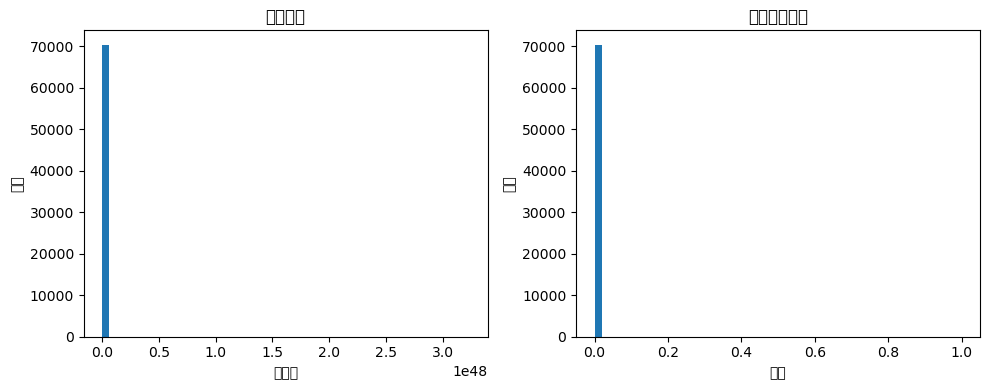

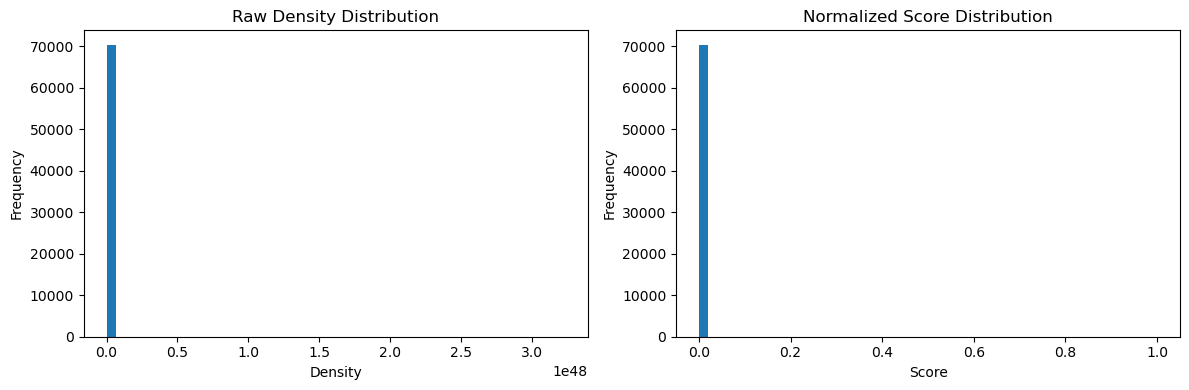

In [26]:
from function import *

if __name__ == '__main__':
    usa_bounds_main = {
        'lon_min': -125,  # 美国本土最西端（华盛顿州）
        'lon_max': -65,   # 美国本土最东端（缅因州）
        'lat_min': 25,    # 美国本土最南端（佛罗里达州）
        'lat_max': 49     # 美国本土最北端（与加拿大接壤）
    }
       
    # 加载数据
    df_abandon = load_abandon(PATHS['us_abandon'])
    df_embedding = load_embedding(PATHS['us_pv_embedding'])


    # Filter df_embedding to only include points within USA mainland bounds
    df_embedding = df_embedding[
        (df_embedding['lon'] >= usa_bounds_main['lon_min']) & 
        (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
        (df_embedding['lat'] >= usa_bounds_main['lat_min']) & 
        (df_embedding['lat'] <= usa_bounds_main['lat_max'])
    ]

    # 填充缺失值
    df_abandon_fill = fill_nonpositive_with_nearest(df_abandon)
    df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)
    
    # 去除重复值
    df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)



    # inspect_kde_data(
    # df_train=df_embedding_fill[NUMERIC_FEATURES + CAT_COLS],
    # df_test=df_abandon_filtered[NUMERIC_FEATURES + CAT_COLS],
    # feature_names=NUMERIC_FEATURES + CAT_COLS)


    # 阶段一建模，使用KDE模型测算相似分数
    kde_pipe = select_and_train_kde(
        df_pos=df_embedding_fill[   
            NUMERIC_FEATURES + CAT_COLS
        ])
    dens, env_scores = score_env(kde_pipe, df_abandon_filtered[NUMERIC_FEATURES + CAT_COLS])
    

    # 检查结果分布
    plt.figure(figsize=(12, 4))

    plt.subplot(121)
    plt.hist(dens, bins=50)
    plt.title('Raw Density Distribution')
    plt.xlabel('Density')
    plt.ylabel('Frequency')

    plt.subplot(122)
    plt.hist(env_scores, bins=50)
    plt.title('Normalized Score Distribution')
    plt.xlabel('Score')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # # 阶段二构建训练集 & 训练分类器
    # df_stage2, unlabeled_idx = prepare_stage2(
    #     df_embedding=df_embedding,
    #     df_abandon_filtered=df_abandon_filtered,
    #     env_scores=env_scores,
    #     include_negatives=False  # 第一次跑可只用正样本
    # )
    # clf = train_stage2(df_stage2)

    # # 5. 阶段 2：预测
    # final_probs = predict_stage2(clf, df_stage2, unlabeled_idx)

    # # 6. 输出 NetCDF
    # ds = build_final_ds(df_abandon_filtered, final_probs)
    # save_netcdf(ds, 'prediction_2020.nc')



    
    
    

In [23]:
# Check NaN counts in df_abandon_filtered
print("NaN counts in df_abandon_filtered:")
for col in df_abandon_filtered[NUMERIC_FEATURES + CAT_COLS].columns:
    nan_count = df_abandon_filtered[NUMERIC_FEATURES + CAT_COLS][col].isna().sum()
    print(f"{col}: {nan_count}")

print("\nNaN counts in df_embedding_fill:")
for col in df_embedding_fill[NUMERIC_FEATURES + CAT_COLS].columns:
    nan_count = df_embedding_fill[NUMERIC_FEATURES + CAT_COLS][col].isna().sum()
    print(f"{col}: {nan_count}")

NaN counts in df_abandon_filtered:
lat: 0
lon: 0
GDPpc: 0
GDPtot: 0
GURdist: 0
DEM: 0
Slope: 0
Population: 0
Powerdist: 0
PrimaryRoad: 0
SecondaryRoad: 0
TertiaryRoad: 0
gdmp: 0
rsds: 0
tas: 0
wind: 0
landcover: 0

NaN counts in df_embedding_fill:
lat: 0
lon: 0
GDPpc: 0
GDPtot: 0
GURdist: 0
DEM: 0
Slope: 0
Population: 0
Powerdist: 0
PrimaryRoad: 0
SecondaryRoad: 0
TertiaryRoad: 0
gdmp: 0
rsds: 0
tas: 0
wind: 0
landcover: 0


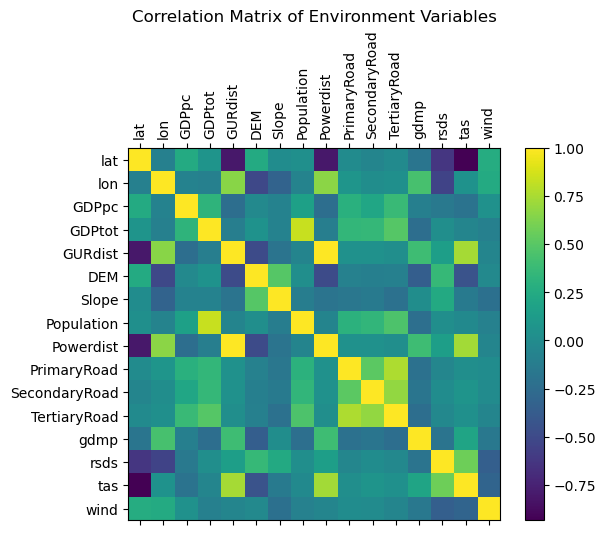

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# 1. 绘制环境变量的相关系数矩阵
env_df = df_abandon_filtered[NUMERIC_FEATURES]
corr = env_df.corr()

plt.figure()
plt.matshow(corr, fignum=1)
plt.xticks(range(len(NUMERIC_FEATURES)), NUMERIC_FEATURES, rotation=90)
plt.yticks(range(len(NUMERIC_FEATURES)), NUMERIC_FEATURES)
plt.title('Correlation Matrix of Environment Variables')
plt.colorbar()
plt.show()

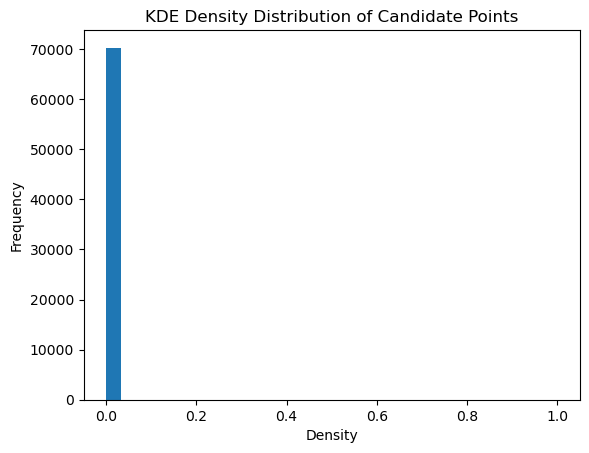

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(env_scores, bins=30)
plt.title('KDE Density Distribution of Candidate Points')
plt.xlabel('Density')
plt.ylabel('Frequency')
plt.show()

# 前期测试

In [47]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

# 1. 定义两表共有的特征，用于聚类和建模
feature_cols = [
    'DEM', 'landcover', 'GDPpc', 'GDPtot', 'GURdist', 'Population',
    'Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad',
    'Slope', 'gdmp', 'rsds', 'tas', 'wind'
]

# 假设 df_embedding 和 df_abandon 均已加载
# 2. 标准化处理
scaler = StandardScaler()
X_embed = scaler.fit_transform(df_embedding[feature_cols])
X_abandon = scaler.transform(df_abandon[feature_cols])

# 3. 在 df_embedding 上训练 GMM，选取最佳成分数
bic_scores = []
gmms = []
for k in range(2, 11):
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_embed)
    bic_scores.append(gmm.bic(X_embed))
    gmms.append(gmm)

best_idx = np.argmin(bic_scores)
best_gmm = gmms[best_idx]
print(f"Selected GMM with {best_gmm.n_components} components")

# 4. 获取聚类后验概率（责任度）
resp_embed = best_gmm.predict_proba(X_embed)
resp_abandon = best_gmm.predict_proba(X_abandon)

# 5. 将责任度添加回原 DataFrame
for i in range(best_gmm.n_components):
    df_embedding[f'cluster_prob_{i}'] = resp_embed[:, i]
    df_abandon[f'cluster_prob_{i}'] = resp_abandon[:, i]

# 6. 构造分类数据集
pos_df = df_embedding.copy()
pos_df['label'] = 1
neg_df = df_abandon.copy()
neg_df['label'] = 0

model_df = pd.concat([pos_df, neg_df], ignore_index=True)

# 7. 提取模型特征与标签
cluster_cols = [f'cluster_prob_{i}' for i in range(best_gmm.n_components)]
X = model_df[cluster_cols]
y = model_df['label']

# 8. 划分训练与测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 9. 训练随机森林分类器
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 10. 评估模型性能
y_pred_proba = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print("Test AUC:", auc)
print(classification_report(y_test, clf.predict(X_test)))

# 11. 对所有弃耕记录进行预测
df_abandon['pv_prob'] = clf.predict_proba(df_abandon[cluster_cols])[:, 1]



Selected GMM with 10 components
Test AUC: 0.9721381153257894
              precision    recall  f1-score   support

           0       0.89      0.97      0.93     14127
           1       0.98      0.90      0.94     17235

    accuracy                           0.93     31362
   macro avg       0.93      0.94      0.93     31362
weighted avg       0.94      0.93      0.93     31362



c:\Users\zpy10\Anaconda3\envs\glbcropland\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\zpy10\Anaconda3\envs\glbcropland\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\zpy10\Anaconda3\envs\glbcropland\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\zpy10\Anaconda3\envs\glbcropland\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25351 (\N{CJK UNIFIED IDEOGRAPH-6307}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\zpy10\Anaconda3\envs\glbcropland\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26631 (\N{CJK

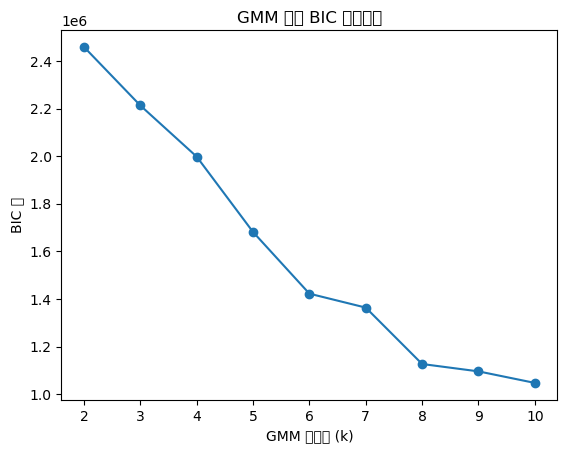

c:\Users\zpy10\Anaconda3\envs\glbcropland\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32452 (\N{CJK UNIFIED IDEOGRAPH-7EC4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\zpy10\Anaconda3\envs\glbcropland\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\zpy10\Anaconda3\envs\glbcropland\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32858 (\N{CJK UNIFIED IDEOGRAPH-805A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\zpy10\Anaconda3\envs\glbcropland\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\zpy10\Anaconda3\envs\glbcropland\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21487 (\N{CJK

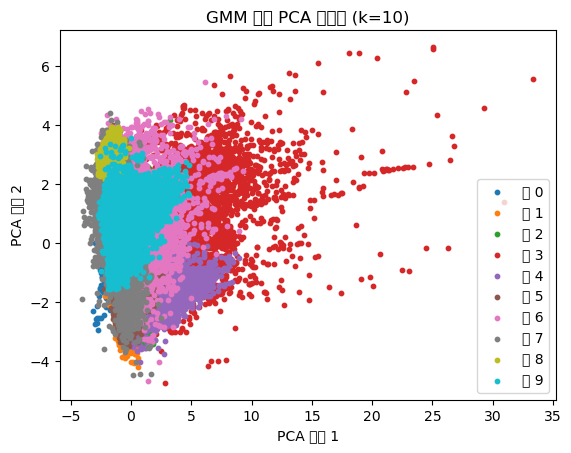

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

# 假设 df_embedding 已加载为 DataFrame
feature_cols = [
    'DEM', 'landcover', 'GDPpc', 'GDPtot', 'GURdist', 'Population',
    'Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad',
    'Slope', 'gdmp', 'rsds', 'tas', 'wind'
]

# 1. 标准化
scaler = StandardScaler()
X_embed = scaler.fit_transform(df_embedding[feature_cols])

# 2. 计算不同成分数的 BIC
ks = range(2, 11)
bic_scores = []
gmms = []
for k in ks:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_embed)
    bic_scores.append(gmm.bic(X_embed))
    gmms.append(gmm)

best_idx = np.argmin(bic_scores)
best_k = ks[best_idx]
best_gmm = gmms[best_idx]

# 3. 绘制 BIC 曲线
plt.figure()
plt.plot(ks, bic_scores, marker='o')
plt.xlabel('GMM 成分数 (k)')
plt.ylabel('BIC 值')
plt.title('GMM 模型 BIC 指标比较')
plt.show()

# 4. PCA 降维至 2 维，并绘制聚类结果散点图
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_embed)
labels = best_gmm.predict(X_embed)

plt.figure()
for lbl in np.unique(labels):
    idx = labels == lbl
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f'簇 {lbl}', s=10)
plt.xlabel('PCA 组件 1')
plt.ylabel('PCA 组件 2')
plt.title(f'GMM 聚类 PCA 可视化 (k={best_k})')
plt.legend()
plt.show()


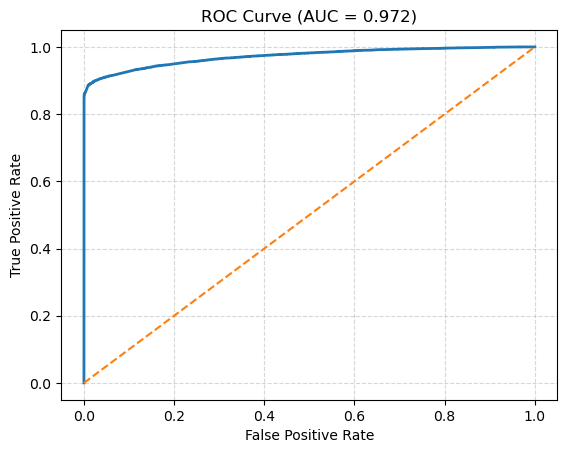

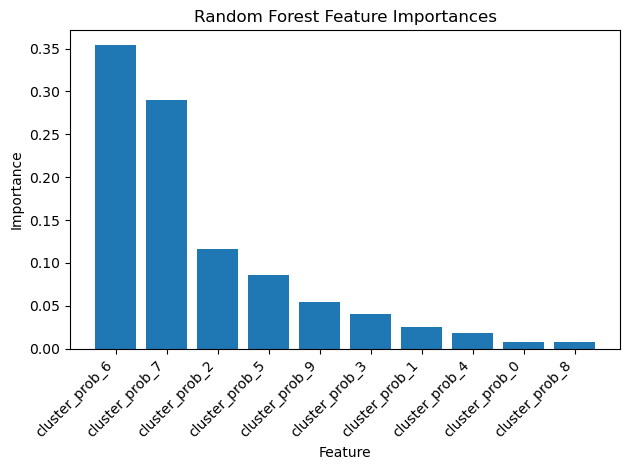

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

# 假设 df_embedding 和 df_abandon 已加载，且包含 cluster_prob_* 列
cluster_cols = [c for c in df_embedding.columns if c.startswith('cluster_prob_')]

# 构造正负样本
pos = df_embedding.copy()
pos['label'] = 1
neg = df_abandon.copy()
neg['label'] = 0

data = pd.concat([pos, neg], ignore_index=True)
X = data[cluster_cols]
y = data['label']

# 划分数据集并训练
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_prob = clf.predict_proba(X_test)[:, 1]

# 1. 绘制 ROC 曲线
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {roc_auc:.3f})')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 2. 绘制特征重要性
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
feat_names = np.array(cluster_cols)[indices]

plt.figure()
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), feat_names, rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.show()
